<a href="https://colab.research.google.com/github/cesong2/Display-Sensor/blob/yngkyng/%EB%94%A5%ED%95%9C_%EB%B6%84%EC%84%9D1%2C2%2C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [3]:
#Load the data
telemetry_df = pd.read_csv("/content/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/PdM_errors.csv")
maint_df = pd.read_csv("/content/PdM_maint.csv")
failures_df = pd.read_csv("/content/PdM_failures.csv")
machines_df = pd.read_csv("/content/PdM_machines.csv")

##1. 사용연식, 에러횟수, 교체횟수, 고장횟수 간 상관관계 찾기
* 사용연식 - machineID의 age (machines.csv)
* 에러횟수 - groupby machineID, count * (errors.csv)
* 교체횟수 - groupby machineID, count * (maint.csv)
* 고장횟수 - groupby machineID, count * (failure.csv)

In [4]:
# 필요한 데이터 추출
machines_age = pd.DataFrame(machines_df[['machineID','age']]).set_index('machineID')
machines_errors = pd.DataFrame(errors_df.groupby('machineID')['errorID'].count())
machines_maint = pd.DataFrame(maint_df.groupby('machineID')['comp'].count())
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [5]:
# 추출한 데이터 합치기
df_machines = pd.concat([machines_age, machines_errors, machines_maint, machines_failures], axis=1)
df_machines.rename(columns={'errorID':'error', 'comp':'replace'},inplace=True)
df_machines

,age,error,replace,failure
machineID,,,,
1,18,35,37,7.0
2,7,28,32,4.0
3,8,39,37,5.0
4,7,31,33,6.0
5,2,38,35,7.0
...,...,...,...,...
96,10,39,33,5.0
97,14,45,34,8.0
98,20,45,37,16.0


In [6]:
# 상관관계 찾기 (피어슨 상관계수 사용)
df_machines.corr(method = "pearson")

,age,error,replace,failure
age,1.000000,0.106931,0.075445,0.476459
error,0.106931,1.000000,-0.026558,0.483735
replace,0.075445,-0.026558,1.000000,-0.030258
failure,0.476459,0.483735,-0.030258,1.000000


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49832 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_

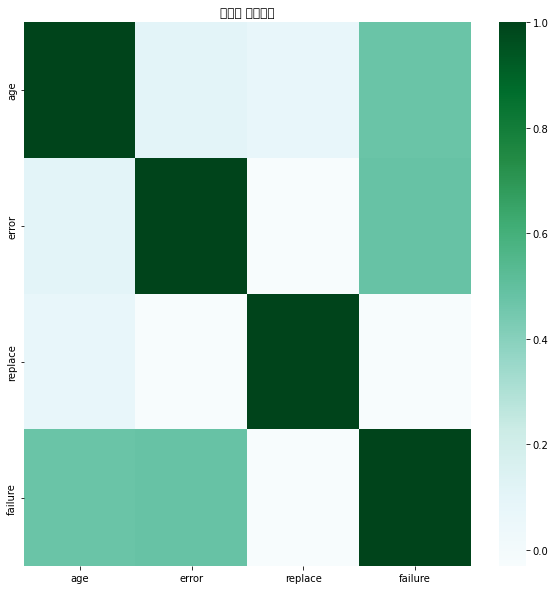

In [7]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.BuGn  #색설정 : BlueGreen
plt.figure(figsize = (10,10))
plt.title("피어슨 상관계수")
sns.heatmap(df_machines.astype(float).corr(), cmap=colormap)

In [ ]:
### 결론 : 사용연식과 고장횟수 사이 / 에러횟수와 고장횟수 사이는 각각 약한 상관관계가 존재함(상관계수 0.47, 0.48)

## 2. 요인들(전압, 회전, 압력, 진동)의 이상치가 고장과 연관성이 있는지
* 요인들 -> telemetry.csv
* 고장 -> failures.csv

In [8]:
#기계별 고장 데이터
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())

In [9]:
telemetry_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


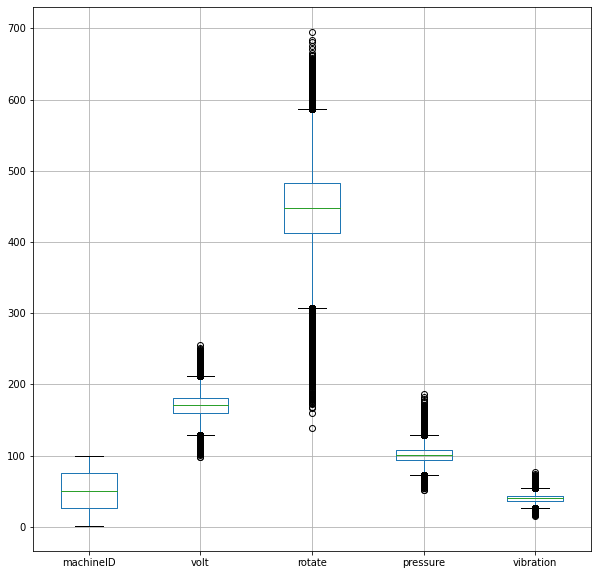

In [10]:
# 각 요인별 이상치 찾기
telemetry_df.boxplot(figsize=(10,10))
plt.show()

In [11]:
import numpy as np

In [52]:
# 각 요인별 이상치 데이터 추출하는 함수 정의
def outlier(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (IQR * 1.5)
    maximum = Q3 + (IQR * 1.5)

    machineID = []
    value = []
    for i in range(len(df[column])):
        if df[column][i]>=maximum or df[column][i]<=minimum:
            machineID.append(df['machineID'][i])
            value.append(df[column][i])
    return pd.DataFrame({'machineID': machineID, column: value})

In [53]:
# 함수 시험작동
volt_outlier = outlier(telemetry_df, 'volt')
volt_outlier.head(10)

,machineID,volt
0,1,215.656488
1,1,129.016707
2,1,127.163620
3,1,213.787102
4,1,121.502718
5,1,119.059047
6,1,216.955936
7,1,237.938518
8,1,215.114898
9,1,223.590823


In [54]:
# 각 요인별 이상치 데이터 추출
volt_outlier = outlier(telemetry_df, 'volt')
rotate_outlier = outlier(telemetry_df, 'rotate')
pressure_outlier = outlier(telemetry_df, 'pressure')
vibration_outlier = outlier(telemetry_df, 'vibration')

In [62]:
# 이상치 데이터에서 기계별로 groupby, 각 이상치가 몇번씩 측정되었는지 count
volt_out_df = pd.DataFrame(volt_outlier.groupby('machineID')['volt'].count())
rotate_out_df = pd.DataFrame(rotate_outlier.groupby('machineID')['rotate'].count())
pressure_out_df = pd.DataFrame(pressure_outlier.groupby('machineID')['pressure'].count())
vibration_out_df = pd.DataFrame(vibration_outlier.groupby('machineID')['vibration'].count())

volt_out_df.rename(columns={'volt':'volt_outliers'},inplace=True)
rotate_out_df.rename(columns={'rotate':'rotate_outliers'},inplace=True)
pressure_out_df.rename(columns={'pressure':'pressure_outliers'},inplace=True)
vibration_out_df.rename(columns={'vibration':'vibration_outliers'},inplace=True)

In [66]:
# 기계별 고장횟수 & 이상치데이터 합치기
machines_outliers = pd.concat([machines_failures, volt_out_df, rotate_out_df, pressure_out_df, vibration_out_df], axis=1)

In [67]:
machines_outliers

,failure,volt_outliers,rotate_outliers,pressure_outliers,vibration_outliers
machineID,,,,,
1,7.0,74,85,137,143
2,4.0,94,83,131,90
3,5.0,62,111,153,94
4,6.0,83,107,114,108
5,7.0,66,89,184,90
...,...,...,...,...,...
96,5.0,74,77,212,102
97,8.0,64,103,180,120
98,16.0,97,98,235,125


In [68]:
# 기계별 고장 횟수와 이상치별 측정 횟수 상관관계 찾기 (피어슨 사용)
machines_outliers.corr(method = "pearson")

,failure,volt_outliers,rotate_outliers,pressure_outliers,vibration_outliers
failure,1.000000,0.102951,0.199934,0.620790,0.532165
volt_outliers,0.102951,1.000000,0.006575,0.029780,-0.070066
rotate_outliers,0.199934,0.006575,1.000000,-0.038409,0.031573
pressure_outliers,0.620790,0.029780,-0.038409,1.000000,0.106246
vibration_outliers,0.532165,-0.070066,0.031573,0.106246,1.000000


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49832 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_

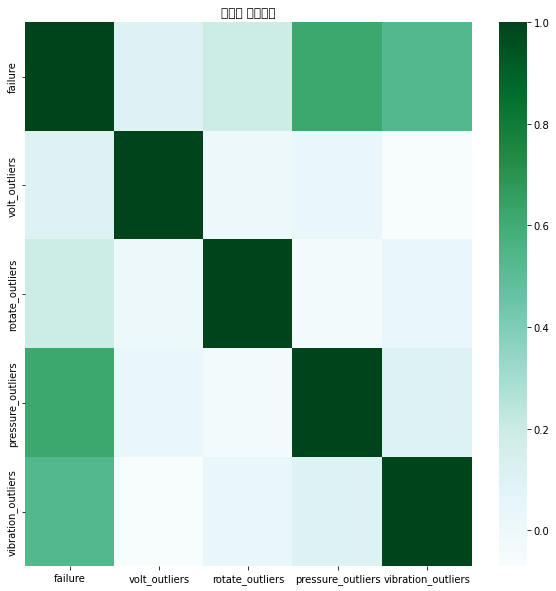

In [69]:
# 히트맵 시각화
matplotlib.rcParams['font.family'] = "NaNumGothic"  #나눔고딕체 사용
colormap = plt.cm.BuGn  #색설정 : BlueGreen
plt.figure(figsize = (10,10))
plt.title("피어슨 상관계수")
sns.heatmap(machines_outliers.astype(float).corr(), cmap=colormap)

In [ ]:
### 고장은 압력과 진동 이상치와 상관성이 있음(상관계수 0.6, 0.5)
### 이후 개선방향 제시: 압력과 진동 이상치 발생 원인을 찾아 줄여주면 좋음.

##4. 모델 종류별 고장률 찾기
* 모델 4종류 (machines.csv)
* 고장횟수 (failures.csv)


In [23]:
# 기계별 고장 데이터 & 기계별 모델 데이터 추출하기
machines_failures = pd.DataFrame(failures_df.groupby('machineID')['failure'].count())
machines_model = pd.DataFrame(machines_df[['machineID','model']]).set_index('machineID')

In [30]:
print(machines_failures.head(2))
print(machines_model.head(2))

           failure
machineID         
1                7
2                4
            model
machineID        
1          model3
2          model4


In [25]:
# 기계별 모델, 고장 데이터 합치기
model_fail = pd.concat([machines_model, machines_failures], axis=1)

In [28]:
model_fail.head(2)

,model,failure
machineID,,
1,model3,7.0
2,model4,4.0


In [39]:
# 모델별 고장 횟수 추출
models_failures = pd.DataFrame(model_fail.groupby('model')['failure'].sum())

# 모델별 보유 개수
models_count = pd.DataFrame(machines_df.groupby('model')['machineID'].count())
models_count.rename(columns={'machineID':'num'},inplace=True)

In [41]:
# 모델별 보유 개수 & 고장 횟수 합치기
models_failures_count = pd.concat([models_count, models_failures], axis=1)

In [43]:
# 고장률 컬럼 추가 (고장횟수/보유개수*100)
models_failures_count['Failure rate'] = models_failures_count['failure'] / models_failures_count['num'] *100

In [44]:
models_failures_count

,num,failure,Failure rate
model,,,
model1,16,189.0,1181.250000
model2,17,168.0,988.235294
model3,35,221.0,631.428571
model4,32,183.0,571.875000


In [70]:
### 결론 : 모델1,2가 고장률이 높은 걸 알 수 있음. 앞으로 기계 전체를 교체 시에는 모델 3 또는 4로 교체하는게 좋을 듯.